# Импорт библиотек

- numpy — библиотека для работы с матрицами больших размерностей
- scipy — библиотека для выполнения научных и инженерных расчётов, в том числе:
    - odeint — функция численного интегрирования
    - minimize — функция минимизации функции вида $y = y(x)$
    - Bounds — функция создания класса Bounds для определения границ минимизации
- matplotlib.pyplot — библиотека для построения графиков

In [14]:
import numpy as np # библиотека для работы с матрицами
from scipy.integrate import odeint # функция численного интегрирования
from scipy.optimize import minimize, Bounds # функции минимизации и создания границ
import matplotlib.pyplot as plt # библиотека для построения графиков

# 1. Описание динамической системы

Необходимо создать функцию, которая описывает нижеописанную динамическую систему.

$
\dot{X_0} = X_1 \\
\dot{X_1} = X_2 \\
\dot{X_2} = U_0 k_e k_1 k_2 - X_0 (k_1 k_2 k_e) - X_1   (k_4 - k_1   k_2   k_\omega + k_1   k_e) - X_2   (k_3 - k_1   k_\omega)
$

Ниже создана функция, которая возвращает левую часть системы, получая в качестве аргументов:
- вектор $X$
- время $t$
- вектор параметров $P = \{U_0, k_e, k_\omega\}$

In [15]:
# P - вектор параметров - (U0, k_e, k_omega)
# функция системы ДУ
def sys(X, t, P=(1,1,1)):
    
    # коэф-ты системы
    k1 = 0.243846
    k2 = 7.787699
    k3 = 5.116065
    k4 = 10.921166
    
    # система диф-ных ур-й
    DX0 = X[1]
    DX1 = X[2]
    DX2 = P[0]*P[1]*k1*k2 - X[0]*(k1*k2*P[1]) - X[1] * (k4 - k1 * k2 * P[2] + k1 * P[1]) - X[2] * (k3 - k1 * P[2])
    
    return [DX0, DX1, DX2]

# 2. Создание функции, которая описывает критерий

Ниже разрабатона функция, реализующая наш критерий, которая имеет вид:
$$
f: R^2 \rightarrow R^1 \\
$$

То есть:
$$
f(k_e, k_\omega) = \int_0^T \varepsilon^2(t)dt \rightarrow \min_{k_e, k_\omega}, где \ \varepsilon(t) = X_0 (t) - U_0 = X_0 (t) -1
$$

In [16]:
# k - вектор коэф-ов - (k_e, k_omega)
def model(k = (1,1)):
    
    U0 = 1
    
    Params = (U0,k[0],k[1])
    
    def sys(X, t, P):
    
        # коэф-ты системы
        k1 = 0.243846
        k2 = 7.787699
        k3 = 5.116065
        k4 = 10.921166

        # система диф-ных ур-й
        DX0 = X[1]
        DX1 = X[2]
        DX2 = P[0]*P[1]*k1*k2 - X[0]*(k1*k2*P[1]) - X[1] * (k4 - k1 * k2 * P[2] + k1 * P[1]) - X[2] * (k3 - k1 * P[2]);

        return [DX0, DX1, DX2]
    
    t = np.linspace(0, 15, 10000) # вектор времени
    X_init = [0, 0, 0]             # начальные условия
    
    X = np.transpose(odeint(sys, X_init, t, args=(Params,))) # решение СЛДУ и последующее траспонирование матрицы решений
    
    res = (X - U0)**2 # Вычитание упр-го сигнала и поэлементное возведение в квадрат
    
    return res.sum() # Суммирование всех элементов

In [17]:
model((10,1))

23181.8888959637

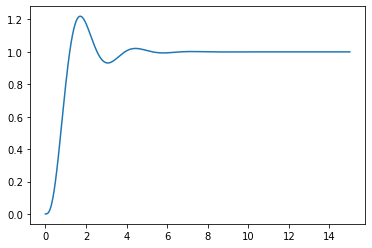

In [18]:
# Результат со случайными коэф-ми
t = np.linspace(0, 15, 100000) # вектор времени
X_init = [0, 0, 0]             # начальные условия
P = [1, 10, 1] # вектор параметров - (U0, k_e, k_omega)
X = np.transpose(odeint(sys, X_init, t, args=(P,))) # решение СЛДУ и последующее траспонирование матрицы решений
plt.plot(t, X[0])

# 3. Минимизация 
## 3.1 Определение ограничений
Предполагаются следующие ограничения:
$$
0.1 < k_e < 1000 \\
0.1 < k_\omega < 1000
$$

In [19]:
k_e_bottom = 0.1 # Нижнее ограничение по k_e
k_e_upper = 1000 # Нижнее ограничение по k_omega
k_omega_bottom = 0.1 # Верхнее ограничение по k_e
k_omega_upper = 1000 # Верхнее ограничение по k_omega

bounds = Bounds([k_e_bottom, k_omega_bottom], [k_e_upper, k_omega_upper])

In [20]:
k0 = np.array([2, 1]) # Начальные условия

In [21]:
res = minimize(model, k0, method='trust-constr', bounds=bounds)
print(res)
print(model((2, 2)))

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 239
      cg_stop_cond: 4
            constr: [array([2.75367984, 0.6922541 ])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.6507363319396973
               fun: 19890.03405111095
              grad: array([-6.33917365e-02,  1.35042554e+03])
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-5.55091212e-02,  3.50676701e+02])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 354
              nhev: 0
               nit: 192
             niter: 192
              njev: 118
        optimality: 350.6767006227466
            status: 2
           success: True
         tr_radius: 1.0000000000000005e-09
            

# 4. Построение графика переходного процесса

In [22]:
# Построение результирующего графика
t = np.linspace(0, 10, 10000) # вектор времени
X_init = [0, 0, 0]             # начальные условия
P = [1, res.x[0], res.x[1]] # вектор параметров - (U0, k_e, k_omega)
X = np.transpose(odeint(sys, X_init, t, args=(P,))) # решение СЛДУ и последующее траспонирование матрицы решений

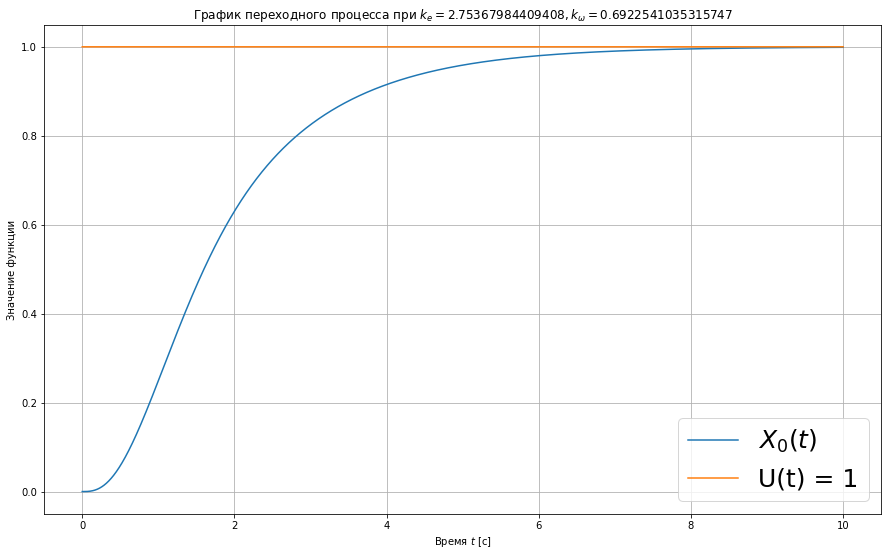

In [25]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(t,X[0], label="$X_0(t)$")
ax.plot(t, np.full(10000, 1), label="U(t) = 1")
ax.legend(loc="lower right", fontsize=25)
ax.set_title("График переходного процесса при $k_e = {}, k_\omega = {}$".format(res.x[0], res.x[1]))
ax.set_xlabel("Время $t$ [с]")
ax.set_ylabel("Значение функции")
ax.grid()

# Вывод

In [24]:
%%timeit 
 res = minimize(model, k0, method='trust-constr', bounds=bounds)

702 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Можно заметить, что выполнение минимизации происходит весьма быстро, что показывает Python с библиотеками для научных расчетов неплохо подходит для выполнения оптимизации коэффициентов САУ по заданному критерию.